# Transfer Learning

Application of [transfer learning](https://keras.io/guides/transfer_learning/) to build a convolutional neural network to tackle the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The idea is to select an existing trained model (e.g., from [Keras](https://keras.io/api/applications/)) and fine-tune it to solve the classification task.

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

import tensorflow as tf
from tensorflow import keras

from keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [97]:
tf.__version__

'2.9.1'

In [98]:
tf.keras.__version__

'2.9.0'

## Dataset Preparation

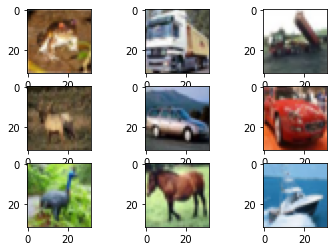

Shape of training dataset: (50000, 32, 32, 3)
<class 'numpy.ndarray'>


In [99]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

print(f'Shape of training dataset: {X_train_full.shape}')
print(type(X_train_full))

According to the [docs](https://keras.io/api/applications/densenet/#densenet201-function), each Keras application expects a certain kind of input preprocessing.

In [100]:
# preprocess data
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

In [101]:
# one-hot encoding of class labels
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [102]:
# validation set
np.random.seed(20)
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

X_train.shape

(45000, 32, 32, 3)

In [103]:
# wrap data into a tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(f'Number of images in training dataset: {train_dataset._tensors[0].shape[0]}')
print(f'Number of labels in training dataset: {train_dataset._tensors[1].shape[0]}')

Number of images in training dataset: 45000
Number of labels in training dataset: 45000


In [104]:
# batch the data and use caching & prefetching to optimize loading speed
batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
val_dataset = val_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

In [105]:
# use random data augmentation to counteract overfitting
data_augmentation = keras.Sequential([keras.layers.RandomRotation(0.1), keras.layers.RandomFlip("horizontal"),])

## Build and Train the Model

The following transfer learning workflow is implemented:
1. Instantiation of a base model (i.e., DenseNet201) and loading pre-trained weights
2. Freeze all layers in base model (avoid large gradient updates that may destroy pretrained features)
3. Create custom model on top of base model
4. Train complete model on new dataset and let it converge on this dataset
5. Unfreeze base model and retrain model end-to-end with low learning rate 

In [106]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

### Converge Custom Model on Dataset

In [115]:
# initialize and configure DenseNet201 base model
input_shape = (32,32,3)
base_model = tf.keras.applications.DenseNet201(include_top=False, input_shape=input_shape, weights="imagenet", pooling='max')
base_model.trainable = False

# integrate data augmentation and preprocessing layers into the model
inputs = keras.Input(shape=input_shape) # instantiates a Keras tensor (i.e. a symbolic tensor-like object)
x = data_augmentation(inputs)
x = base_model(x, training=False) # activate inference mode (for batchnorm layers)

layers_custom = keras.Sequential(
    [
        keras.layers.Dense(units=256, activation='relu', kernel_initializer=keras.initializers.he_normal(), kernel_regularizer=keras.regularizers.l2()),
        keras.layers.Dense(units=128, activation='relu', kernel_initializer=keras.initializers.he_normal(), kernel_regularizer=keras.regularizers.l2()),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(activation='softmax', kernel_initializer=keras.initializers.he_normal(), units=10),
    ])

outputs = layers_custom(x)
model_custom = keras.Model(inputs, outputs)

model_custom.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_11 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 sequential_13 (Sequential)  (None, 10)                525962    
                                                                 
Total params: 18,847,946
Trainable params: 525,962
Non-trainable params: 18,321,984
_________________________________________________________________


In [116]:
model_custom.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_custom.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks = [early_stopping], verbose=1)


Epoch 1/20
1407/1407 [==============================] - 417s 291ms/step - loss: 2.2802 - accuracy: 0.5067 - val_loss: 1.3947 - val_accuracy: 0.5972
Epoch 2/20
1407/1407 [==============================] - 381s 271ms/step - loss: 1.4750 - accuracy: 0.5526 - val_loss: 1.2887 - val_accuracy: 0.6130
Epoch 3/20
1407/1407 [==============================] - 384s 273ms/step - loss: 1.4164 - accuracy: 0.5586 - val_loss: 1.2377 - val_accuracy: 0.6294
Epoch 4/20
1407/1407 [==============================] - 382s 272ms/step - loss: 1.3804 - accuracy: 0.5707 - val_loss: 1.1943 - val_accuracy: 0.6448
Epoch 5/20
1407/1407 [==============================] - 376s 268ms/step - loss: 1.3576 - accuracy: 0.5752 - val_loss: 1.2113 - val_accuracy: 0.6314
Epoch 6/20
1407/1407 [==============================] - 383s 272ms/step - loss: 1.3421 - accuracy: 0.5779 - val_loss: 1.1713 - val_accuracy: 0.6446
Epoch 7/20
1407/1407 [==============================] - 380s 270ms/step - loss: 1.3297 - accuracy: 0.5820 - val_

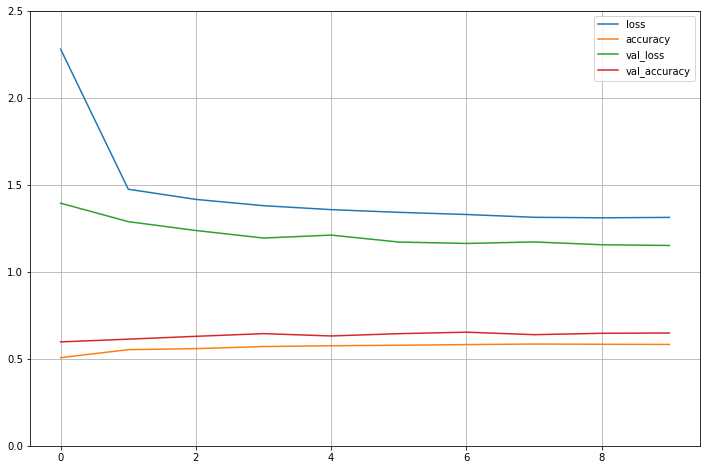

In [119]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 2.5)
plt.grid(True)
plt.show()

### Fine Tuning of Complete Model

In this procedure, we unfreeze the layers of the base model. Importantly, the base model keeps running in inference mode because 'training=False' was configured earlier. This has some implications for the batchnorm layers as they will not update their batch statistics and therefore protect against discarding the learned features of the base model. Furthermore, the comoplete model needs to be recompiled, preferably with a low learning rate.

In [120]:
base_model.trainable = True
model_custom_finetuned = keras.Model(inputs, outputs)

model_custom_finetuned.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_11 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 sequential_13 (Sequential)  (None, 10)                525962    
                                                                 
Total params: 18,847,946
Trainable params: 18,618,890
Non-trainable params: 229,056
_________________________________________________________________


In [121]:
model_custom_finetuned.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_custom_finetuned.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks = [early_stopping], verbose=1)

Epoch 1/10
1407/1407 [==============================] - 960s 672ms/step - loss: 0.9956 - accuracy: 0.6960 - val_loss: 0.7737 - val_accuracy: 0.7762
Epoch 2/10
1407/1407 [==============================] - 1017s 723ms/step - loss: 0.7881 - accuracy: 0.7681 - val_loss: 0.6885 - val_accuracy: 0.8030
Epoch 3/10
1407/1407 [==============================] - 1034s 735ms/step - loss: 0.7056 - accuracy: 0.7954 - val_loss: 0.6278 - val_accuracy: 0.8218
Epoch 4/10
1407/1407 [==============================] - 1011s 719ms/step - loss: 0.6466 - accuracy: 0.8155 - val_loss: 0.6248 - val_accuracy: 0.8208
Epoch 5/10
1407/1407 [==============================] - 1009s 717ms/step - loss: 0.5929 - accuracy: 0.8330 - val_loss: 0.6010 - val_accuracy: 0.8320
Epoch 6/10
1407/1407 [==============================] - 1004s 713ms/step - loss: 0.5550 - accuracy: 0.8454 - val_loss: 0.6128 - val_accuracy: 0.8302
Epoch 7/10
1407/1407 [==============================] - 1014s 721ms/step - loss: 0.5120 - accuracy: 0.8603 

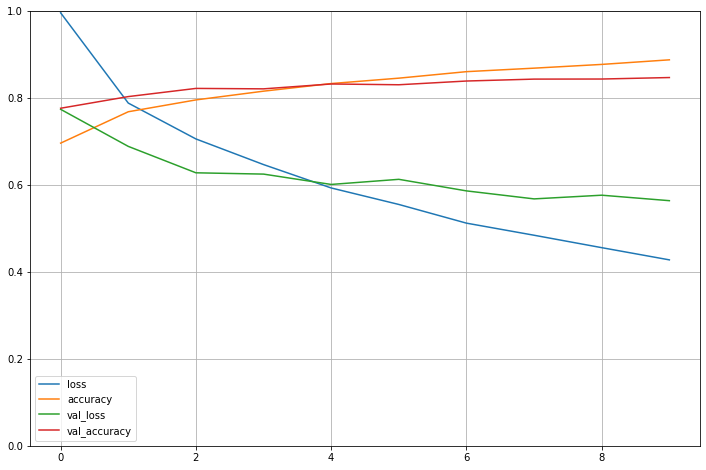

In [123]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1.0)
plt.grid(True)
plt.show()

### Save the Model

In [124]:
#model_custom_finetuned.save('cifar10.h5') 

## Evaluation on Test Data

In [125]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 91s 282ms/step - loss: 0.5791 - accuracy: 0.8456


[0.579137921333313, 0.8456000089645386]